# An Effective Android Ransomware Detection Through Multi-Factor Feature Filtration and Recurrent Neural Network
## Introduction
### Data description

The CICAndMal2017 dataset is creation of the Canadian Institute for Cybersecurity (CIC), developed in 2017 to facilitate research and analysis of ransomware behavior and its impact on various systems.
The dataset contains a collection of ransomware-related data, including network traffic captures, ransomware executables, and associated artifacts. The dataset exhibits differnt forms and in this project, the CSV files would be used.

### Aim of this experiment:
    1. Design and implement algorithms that can distinguish ransomware behavior from legitimate activities, utilizing LSTM model.

### Import all libraries neccessary for this project

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.callbacks import EarlyStopping
import math
from tensorflow.keras.optimizers import Adam


### Import all data, select necessary features, convert the timeframe to usable format add a file number and concatenate each dataset

In [2]:
%matplotlib inline

In [3]:
directories = ["Charger", "Jisut", "Koler", "Lockerpin", "Pletor", 
               "PornDroid", "RansomBO", "Simplocker", "SVpeng", "WannaLocker", "Benign"]
datasets = {}
df_all = pd.DataFrame()
label_encoder = LabelEncoder()

features_to_select = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 
                     'Protocol', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 
                     'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 
                     'Flow IAT Max', 'Flow IAT Min', 'Max Packet Length', 'Packet Length Variance', 
                     'Avg Bwd Segment Size', 'Subflow Bwd Packets', 'Init_Win_bytes_forward', 
                     'Init_Win_bytes_backward', 'Label']

all_labels = []
for directory in directories:
    dataframes = []  
    
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):  
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            
            # cleaning data
            df = df.rename(columns=lambda x: x.strip())
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
            
            # Extract time-based features
            df['Year'] = df['Timestamp'].dt.year
            df['Month'] = df['Timestamp'].dt.month
            df['Day'] = df['Timestamp'].dt.day
            df['Hour'] = df['Timestamp'].dt.hour
            df['Minute'] = df['Timestamp'].dt.minute
            df['Second'] = df['Timestamp'].dt.second
            
            # features selection
            df = df[features_to_select] 
            
            # add one extra column
            df["file_number"] = len(dataframes) + 1
            
            dataframes.append(df)
            if df_all.shape[0] == 0:
                df_all = df
            else:
                frames = [df_all, df]
                df_all = pd.concat(frames, ignore_index=True)

            all_labels.extend(df['Label'].unique())

    datasets[directory] = pd.concat(dataframes, ignore_index=True)

label_encoder.fit(all_labels)

def create_tag_column(label):
    if label == 1:
        return 0  
    else:
        return 1  

for directory in directories:
    datasets[directory]['Label'] = label_encoder.transform(datasets[directory]['Label']) + 1
    datasets[directory]['tag'] = datasets[directory]['Label'].apply(create_tag_column)
    
df_all['Label'] = label_encoder.transform(df_all['Label']) + 1
df_all["Source IP"] = label_encoder.fit_transform(df_all["Source IP"])
df_all["Destination IP"] = label_encoder.fit_transform(df_all["Destination IP"])
df_all['tag'] = df_all['Label'].apply(create_tag_column)

In [4]:
df_all.shape

(759491, 27)

In [5]:
len(df_all[df_all['tag'] == 0])

410548

### Select only 50k ransomware and 50k benign file at random

In [6]:
ransomware_data = df_all[df_all['tag'] == 1]
benign_data = df_all[df_all['tag'] == 0]


ransomware_data = ransomware_data.sample(frac=1, random_state=42)
benign_data = benign_data.sample(frac=1, random_state=42)

num_samples = 300000
ransomware_data = ransomware_data.head(num_samples)
benign_data = benign_data.head(num_samples)

balanced_df = pd.concat([ransomware_data, benign_data], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42)

### Check columns data type and NAN value

In [7]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 4242 to 121958
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Source IP                    600000 non-null  int32  
 1   Source Port                  600000 non-null  int64  
 2   Destination IP               600000 non-null  int32  
 3   Destination Port             600000 non-null  int64  
 4   Protocol                     600000 non-null  int64  
 5   Year                         600000 non-null  int32  
 6   Month                        600000 non-null  int32  
 7   Day                          600000 non-null  int32  
 8   Hour                         600000 non-null  int32  
 9   Minute                       600000 non-null  int32  
 10  Second                       600000 non-null  int32  
 11  Total Length of Fwd Packets  600000 non-null  float64
 12  Fwd Packet Length Max        600000 non-null  float64
 13  F

In [8]:
balanced_df.isna().sum().sort_values(ascending=False)   

Source IP                      0
Fwd Packet Length Mean         0
file_number                    0
Label                          0
Init_Win_bytes_backward        0
Init_Win_bytes_forward         0
Subflow Bwd Packets            0
Avg Bwd Segment Size           0
Packet Length Variance         0
Max Packet Length              0
Flow IAT Min                   0
Flow IAT Max                   0
Fwd Packet Length Std          0
Fwd Packet Length Min          0
Source Port                    0
Fwd Packet Length Max          0
Total Length of Fwd Packets    0
Second                         0
Minute                         0
Hour                           0
Day                            0
Month                          0
Year                           0
Protocol                       0
Destination Port               0
Destination IP                 0
tag                            0
dtype: int64

### View all the dataset

In [9]:
for direct in directories:
    print(direct)
    display(datasets[direct])

Charger


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.211,48478,157.240.18.10,443,6,2017,8,28,2,19,...,190.0,31.0,240.250000,15.5,2,1550,122,2,1,1
1,10.42.0.211,42881,31.13.71.1,443,6,2017,8,28,2,19,...,216598.0,0.0,0.000000,0.0,0,1386,-1,2,1,1
2,10.42.0.211,42881,31.13.71.1,443,6,2017,8,28,2,19,...,922042.0,0.0,0.000000,0.0,0,1386,-1,2,1,1
3,10.42.0.211,42881,31.13.71.1,443,6,2017,8,28,2,19,...,3679063.0,0.0,0.000000,0.0,0,1386,-1,2,1,1
4,10.42.0.211,37257,180.149.138.197,80,6,2017,8,28,2,20,...,68.0,438.0,35305.142857,109.5,4,65535,123,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39546,10.42.0.211,35783,10.42.0.1,53,17,2017,8,30,8,48,...,688332.0,92.0,1160.333333,92.0,1,-1,-1,2,10,1
39547,10.42.0.211,16922,10.42.0.1,53,17,2017,8,30,8,57,...,187910.0,139.0,3675.000000,139.0,1,-1,-1,2,10,1
39548,10.42.0.211,33772,123.125.29.220,80,6,2017,8,30,9,20,...,995247.0,0.0,0.000000,0.0,0,65535,-1,2,10,1
39549,10.42.0.211,33200,239.255.255.250,1900,17,2017,8,30,9,6,...,47.0,133.0,0.300000,0.0,0,-1,-1,2,10,1


Jisut


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.211,46071,172.217.10.74,443,6,2017,8,21,11,53,...,37232.0,0.0,0.000000,0.000000,1,1548,170,3,1,1
1,10.42.0.211,39738,172.217.7.10,443,6,2017,8,21,11,53,...,48798.0,0.0,0.000000,0.000000,1,1903,189,3,1,1
2,10.42.0.211,36658,172.217.10.74,443,6,2017,8,21,11,53,...,37261.0,0.0,0.000000,0.000000,1,2089,175,3,1,1
3,10.42.0.211,43714,111.221.77.148,40010,6,2017,8,21,11,53,...,144911.0,271.0,21818.700000,4.000000,1,1420,37,3,1,1
4,10.42.0.211,41325,40.122.162.208,443,6,2017,8,21,11,53,...,2565.0,101.0,2513.809524,50.500000,2,1595,514,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25667,10.42.0.211,11911,10.42.0.1,53,17,2017,8,22,3,20,...,47679.0,84.0,867.000000,84.000000,1,-1,-1,3,10,1
25668,10.42.0.211,42299,239.255.255.250,1900,17,2017,8,22,2,47,...,60.0,133.0,0.300000,0.000000,0,-1,-1,3,10,1
25669,10.42.0.211,5353,224.0.0.251,5353,17,2017,8,22,3,18,...,36.0,61.0,0.000000,0.000000,0,-1,-1,3,10,1
25670,10.42.0.211,43153,104.254.66.16,443,6,2017,8,22,3,9,...,8.0,1460.0,238403.429167,527.571429,7,65535,30,3,10,1


Koler


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,157.240.18.36,443,10.42.0.211,32773,6,2017,8,22,3,49,...,46.0,42.0,588.000000,0.0,0,120,-1,4,1,1
1,10.42.0.211,32773,157.240.18.36,443,6,2017,8,22,3,49,...,79.0,42.0,441.000000,0.0,0,1431,-1,4,1,1
2,31.13.71.37,443,10.42.0.211,33749,6,2017,8,22,3,49,...,42.0,42.0,588.000000,0.0,0,256,-1,4,1,1
3,10.42.0.211,33749,31.13.71.37,443,6,2017,8,22,3,49,...,94.0,42.0,441.000000,0.0,0,2223,-1,4,1,1
4,10.42.0.211,35590,111.221.77.148,40010,6,2017,8,22,3,49,...,43.0,271.0,19442.400000,2.0,2,1420,35,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44550,10.42.0.211,58127,10.42.0.1,53,17,2017,8,24,10,15,...,23874.0,97.0,1365.333333,97.0,1,-1,-1,4,10,1
44551,202.77.129.54,443,10.42.0.211,56648,6,2017,8,24,10,59,...,79135.0,0.0,0.000000,0.0,1,115,1369,4,10,1
44552,10.42.0.211,43599,151.101.1.140,443,6,2017,8,24,10,54,...,117.0,0.0,0.000000,0.0,0,0,-1,4,10,1
44553,10.42.0.211,35402,10.42.0.1,53,17,2017,8,24,10,15,...,46577.0,84.0,867.000000,84.0,1,-1,-1,4,10,1


Lockerpin


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.211,39195,172.217.9.234,443,6,2017,8,24,12,3,...,36601.0,0.0,0.000000,0.0,1,1726,179,5,1,1
1,10.42.0.211,46466,172.217.10.97,443,6,2017,8,24,12,3,...,37045.0,0.0,0.000000,0.0,1,1594,175,5,1,1
2,10.42.0.211,47823,216.58.219.196,443,6,2017,8,24,12,3,...,37152.0,0.0,0.000000,0.0,1,1593,175,5,1,1
3,10.42.0.211,39388,208.80.154.224,80,6,2017,8,24,12,3,...,244.0,490.0,36990.444444,122.5,4,65535,59,5,1,1
4,10.42.0.211,51831,74.125.29.102,443,6,2017,8,24,12,3,...,290.0,23.0,176.333333,0.0,0,1638,-1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25302,208.80.154.224,443,10.42.0.211,44229,6,2017,8,28,11,22,...,3270.0,0.0,0.000000,0.0,1,59,1386,5,10,1
25303,10.42.0.211,9864,10.42.0.1,53,17,2017,8,28,11,25,...,62909.0,226.0,12805.333333,226.0,1,-1,-1,5,10,1
25304,10.42.0.211,36429,10.42.0.1,53,17,2017,8,28,11,19,...,31953.0,51.0,85.333333,51.0,1,-1,-1,5,10,1
25305,10.42.0.211,5353,224.0.0.251,5353,17,2017,8,28,11,38,...,18.0,245.0,6396.000000,0.0,0,-1,-1,5,10,1


Pletor


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,172.217.12.206,80,10.42.0.42,50379,6,2017,8,30,2,5,...,245971.0,0.0,0.000000,0.0,0,170,-1,6,1,1
1,172.217.12.206,80,10.42.0.42,50379,6,2017,8,30,2,5,...,984204.0,0.0,0.000000,0.0,0,170,-1,6,1,1
2,172.217.12.206,80,10.42.0.42,50379,6,2017,8,30,2,6,...,3936211.0,0.0,0.000000,0.0,0,170,-1,6,1,1
3,157.56.52.23,40033,10.42.0.42,58749,6,2017,8,30,2,6,...,314040.0,0.0,0.000000,0.0,0,33,-1,6,1,1
4,157.56.52.23,40033,10.42.0.42,58749,6,2017,8,30,2,6,...,1268101.0,0.0,0.000000,0.0,0,33,-1,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4710,10.42.0.42,30764,10.42.0.1,53,17,2017,8,31,10,19,...,24847.0,138.0,3605.333333,138.0,1,-1,-1,6,10,1
4711,10.42.0.42,15506,10.42.0.1,53,17,2017,8,31,10,21,...,1161.0,161.0,5461.333333,161.0,1,-1,-1,6,10,1
4712,10.42.0.42,17406,10.42.0.1,53,17,2017,8,31,10,17,...,53951.0,213.0,10443.000000,213.0,1,-1,-1,6,10,1
4713,10.42.0.42,46360,31.211.81.50,10180,17,2017,8,31,10,17,...,5683.0,26.0,17.454545,26.0,5,-1,-1,6,10,1


PornDroid


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.211,54481,216.58.219.234,443,6,2017,8,30,10,26,...,36700.0,0.0,0.000000,0.0,1,1637,181,7,1,1
1,10.42.0.211,36689,216.58.219.234,443,6,2017,8,30,10,26,...,36483.0,0.0,0.000000,0.0,1,2949,181,7,1,1
2,10.42.0.211,44595,172.217.10.46,443,6,2017,8,30,10,26,...,205.0,23.0,176.333333,0.0,2,1419,185,7,1,1
3,10.42.0.211,46117,216.58.219.225,443,6,2017,8,30,10,26,...,36640.0,0.0,0.000000,0.0,1,1594,175,7,1,1
4,10.42.0.211,50580,172.217.11.4,443,6,2017,8,30,10,26,...,36750.0,0.0,0.000000,0.0,1,1593,175,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46077,180.149.134.141,80,10.42.0.211,60901,6,2017,8,31,2,37,...,9854.0,0.0,0.000000,0.0,1,115,1369,7,10,1
46078,88.212.201.205,443,10.42.0.211,57813,6,2017,8,31,3,20,...,148940.0,0.0,0.000000,0.0,1,543,1419,7,10,1
46079,10.42.0.211,38636,64.71.142.81,443,6,2017,8,31,2,44,...,301.0,0.0,0.000000,0.0,0,0,-1,7,10,1
46080,140.205.164.47,443,10.42.0.211,58911,6,2017,8,31,3,21,...,53419.0,0.0,0.000000,0.0,1,11679,65535,7,10,1


RansomBO


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,157.240.2.36,443,10.42.0.151,59285,6,2017,8,29,8,43,...,37.0,42.0,588.000000,0.000000,0,131,-1,8,1,1
1,10.42.0.151,59285,157.240.2.36,443,6,2017,8,29,8,43,...,13.0,42.0,441.000000,0.000000,0,1453,-1,8,1,1
2,10.42.0.151,59285,157.240.2.36,443,6,2017,8,29,8,43,...,220899.0,42.0,588.000000,0.000000,0,1453,-1,8,1,1
3,10.42.0.151,34552,172.217.12.174,443,6,2017,8,29,8,43,...,17.0,1418.0,164309.238095,213.625000,8,65535,176,8,1,1
4,10.42.0.151,50658,206.126.112.140,443,6,2017,8,29,8,43,...,2.0,1448.0,357150.464510,1436.323340,934,65535,123,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39854,10.42.0.151,48599,172.217.7.3,443,17,2017,8,30,12,14,...,24.0,1350.0,355749.897436,453.166667,6,-1,-1,8,10,1
39855,10.42.0.151,60702,10.42.0.1,53,17,2017,8,30,12,36,...,24159.0,113.0,1323.000000,113.000000,1,-1,-1,8,10,1
39856,10.42.0.151,53581,31.13.80.12,443,6,2017,8,30,12,46,...,6.0,1398.0,199125.485380,485.375000,8,65535,114,8,10,1
39857,10.42.0.151,33718,104.244.42.65,443,6,2017,8,30,12,56,...,91.0,0.0,0.000000,0.000000,0,0,-1,8,10,1


Simplocker


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.151,53572,172.217.10.74,443,6,2017,8,24,9,43,...,483.0,31.0,320.333333,0.000,0,1404,-1,9,1,1
1,172.217.10.74,443,10.42.0.151,53572,6,2017,8,24,9,43,...,242.0,0.0,0.000000,0.000,0,181,-1,9,1,1
2,157.240.2.36,443,10.42.0.151,60283,6,2017,8,24,9,43,...,38.0,42.0,588.000000,0.000,0,131,-1,9,1,1
3,10.42.0.151,60283,157.240.2.36,443,6,2017,8,24,9,43,...,128.0,42.0,441.000000,0.000,0,1436,-1,9,1,1
4,10.42.0.151,40671,172.217.6.238,443,6,2017,8,24,9,43,...,15.0,1418.0,164325.314286,213.375,8,65535,176,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36335,10.42.0.151,31334,10.42.0.1,53,17,2017,8,31,1,47,...,911.0,83.0,972.000000,83.000,1,-1,-1,9,10,1
36336,10.42.0.151,45632,23.194.140.128,443,6,2017,8,31,1,27,...,72.0,0.0,0.000000,0.000,0,0,-1,9,10,1
36337,10.42.0.151,48968,10.42.0.1,53,17,2017,8,31,1,53,...,255381.0,180.0,7008.333333,180.000,1,-1,-1,9,10,1
36338,10.42.0.151,39066,10.42.0.1,53,17,2017,8,31,1,46,...,85671.0,215.0,8965.333333,215.000,1,-1,-1,9,10,1


SVpeng


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.42,44804,31.13.80.5,443,6,2017,8,25,9,0,...,9.0,31.0,192.200000,10.333333,3,1386,122,10,1,1
1,10.42.0.42,45779,157.240.2.20,443,6,2017,8,25,9,0,...,232670.0,0.0,0.000000,0.000000,0,1386,-1,10,1,1
2,10.42.0.42,45779,157.240.2.20,443,6,2017,8,25,9,0,...,957459.0,0.0,0.000000,0.000000,0,1386,-1,10,1,1
3,10.42.0.42,44589,172.217.3.106,443,6,2017,8,25,9,0,...,36426.0,0.0,0.000000,0.000000,1,4394,192,10,1,1
4,10.42.0.42,45779,157.240.2.20,443,6,2017,8,25,9,0,...,3846051.0,0.0,0.000000,0.000000,0,1386,-1,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54156,54.193.253.3,443,10.42.0.42,59571,6,2017,8,30,9,31,...,7366.0,0.0,0.000000,0.000000,1,58,1641,10,11,1
54157,10.42.0.42,60726,123.125.29.220,80,6,2017,8,30,9,2,...,307374.0,0.0,0.000000,0.000000,1,1386,137,10,11,1
54158,10.42.0.42,20871,10.42.0.1,53,17,2017,8,30,9,22,...,101.0,34.0,0.000000,34.000000,1,-1,-1,10,11,1
54159,10.42.0.42,48852,10.42.0.1,53,17,2017,8,30,9,3,...,564437.0,140.0,3960.333333,140.000000,1,-1,-1,10,11,1


WannaLocker


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,157.240.2.36,443,10.42.0.151,51961,6,2017,8,21,10,13,...,38.0,42.0,588.000000,0.000000,0,131,-1,11,1,1
1,10.42.0.151,51961,157.240.2.36,443,6,2017,8,21,10,13,...,884.0,42.0,441.000000,0.000000,0,1436,-1,11,1,1
2,10.42.0.151,42453,131.253.61.66,443,6,2017,8,21,10,13,...,6.0,1460.0,422740.957143,944.909091,11,65535,63445,11,1,1
3,10.42.0.151,42453,131.253.61.66,443,6,2017,8,21,10,13,...,102.0,0.0,0.000000,0.000000,0,65535,-1,11,1,1
4,10.42.0.151,36548,172.217.12.170,443,6,2017,8,21,10,14,...,36775.0,0.0,0.000000,0.000000,1,1546,170,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32696,10.42.0.151,53849,10.42.0.1,53,17,2017,8,23,4,45,...,24707.0,199.0,7600.333333,199.000000,1,-1,-1,11,10,1
32697,10.42.0.151,34559,96.126.100.203,123,17,2017,8,23,4,43,...,81388.0,48.0,0.000000,48.000000,1,-1,-1,11,10,1
32698,10.42.0.151,23177,10.42.0.1,53,17,2017,8,23,4,43,...,61591.0,98.0,1160.333333,98.000000,1,-1,-1,11,10,1
32699,10.42.0.151,30407,10.42.0.1,53,17,2017,8,23,4,44,...,24831.0,153.0,4563.000000,153.000000,1,-1,-1,11,10,1


Benign


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Year,Month,Day,Hour,Minute,...,Flow IAT Min,Max Packet Length,Packet Length Variance,Avg Bwd Segment Size,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,Label,file_number,tag
0,10.42.0.211,51023,172.217.2.174,443,6,2017,6,16,3,55,...,24.0,1418.0,316423.066667,571.875000,8,65535,353,1,1,0
1,10.42.0.211,51023,172.217.2.174,443,6,2017,6,16,3,55,...,349.0,23.0,176.333333,0.000000,0,1594,-1,1,1,0
2,10.42.0.211,34259,172.217.12.174,443,6,2017,6,16,3,55,...,119.0,23.0,176.333333,0.000000,0,1486,-1,1,1,0
3,10.42.0.211,55509,172.217.10.74,443,6,2017,6,16,3,55,...,37055.0,31.0,320.333333,0.000000,1,1548,391,1,1,0
4,10.42.0.211,44852,172.217.2.174,443,6,2017,6,16,3,55,...,55.0,753.0,53556.527473,43.857143,7,65535,352,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410543,10.42.0.151,35516,104.244.42.193,443,6,2017,6,23,7,48,...,7.0,1448.0,205671.669951,467.916667,12,65535,131,1,600,0
410544,10.42.0.151,53732,172.217.9.227,443,17,2017,6,23,7,44,...,10.0,1350.0,431849.247619,633.333333,9,-1,-1,1,600,0
410545,10.42.0.151,41070,172.217.11.10,443,6,2017,6,23,7,53,...,32853.0,0.0,0.000000,0.000000,0,413,-1,1,600,0
410546,10.42.0.151,49740,31.13.71.36,443,6,2017,6,23,7,47,...,7.0,1398.0,209587.294118,544.571429,7,65535,114,1,600,0


### Classify the Feature and Normalize the Feature

In [10]:
X = balanced_df.drop(["file_number", "tag"], axis="columns")
y = balanced_df["tag"]

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

min_max_scaler = MinMaxScaler()
X_minmax_scaled = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_standard_scaled, y, test_size=0.3, random_state=42)


### Split the dataset into train, test and validation with ratio of 70, 15, 15

In [11]:
X_train.shape

(420000, 25)

In [12]:
X_test.shape

(180000, 25)

### Performed sequence preparation with padding

In [13]:
X_train = X_train
X_test = X_test

def create_sequences_with_padding(data, time_steps):
    num_samples, num_features = data.shape
    sequences = []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i+time_steps, :])
    sequences = np.array(sequences)

    if len(sequences) < num_samples:
        padding = np.zeros((num_samples - len(sequences), time_steps, num_features))
        sequences = np.vstack((sequences, padding))

    return sequences

time_steps = 10
num_features = 25

X_train_reshaped = create_sequences_with_padding(X_train, time_steps)
X_test_reshaped = create_sequences_with_padding(X_test, time_steps)


print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)


X_train_reshaped shape: (420000, 10, 25)
X_test_reshaped shape: (180000, 10, 25)


In [14]:
X_train_reshaped = X_train_reshaped.astype(np.float32)  
X_test_reshaped = X_test_reshaped.astype(np.float32)

### Define the LSTM architecture

In [31]:
model = Sequential()
model.add(LSTM(128, input_shape=(10, 25), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2)) 
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(32))  
model.add(BatchNormalization())
model.add(Dense(64, activation='tanh')) 
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.add(BatchNormalization())

In [33]:
early_stopping = EarlyStopping(
    monitor='loss',     
    patience=5,             
    verbose=1,              
    restore_best_weights=True  
)

In [34]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [35]:
model.add(Dropout(0.6))

In [36]:
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
3282/3282 [==============================] - 228s 64ms/step - loss: 6.7199 - accuracy: 0.5422
Epoch 2/10
3282/3282 [==============================] - 200s 61ms/step - loss: 6.3988 - accuracy: 0.5648
Epoch 3/10
3282/3282 [==============================] - 207s 63ms/step - loss: 6.2225 - accuracy: 0.5778
Epoch 4/10
3282/3282 [==============================] - 214s 65ms/step - loss: 5.9902 - accuracy: 0.5941
Epoch 5/10
3282/3282 [==============================] - 200s 61ms/step - loss: 5.7192 - accuracy: 0.6130
Epoch 6/10
3282/3282 [==============================] - 185s 56ms/step - loss: 5.6548 - accuracy: 0.6194
Epoch 7/10
3282/3282 [==============================] - 154s 47ms/step - loss: 5.4374 - accuracy: 0.6318
Epoch 8/10
3282/3282 [==============================] - 153s 47ms/step - loss: 5.2526 - accuracy: 0.6461
Epoch 9/10
3282/3282 [==============================] - 150s 46ms/step - loss: 4.9098 - accuracy: 0.6734
Epoch 10/10
3282/3282 [==============================] 

In [37]:
train_accuracy = history.history['accuracy']

In [38]:
len(train_accuracy)

10

### Plotting the graph showing the level of accuracy when fitting the training and validation data

In [39]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

5625/5625 [==============================] - 70s 10ms/step - loss: 0.2007 - accuracy: 0.9904
Test Loss: 0.2007
Test Accuracy: 0.9904


In [40]:
y_pred_probs = model.predict(X_test_reshaped).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

5625/5625 [==============================] - 49s 9ms/step


### Plotting the Confusion Matrix

In [41]:
cm = confusion_matrix(y_test, y_pred)

In [42]:
y_test[y_test == 1].shape

(89927,)

In [43]:
class_labels=['normal', 'attack']

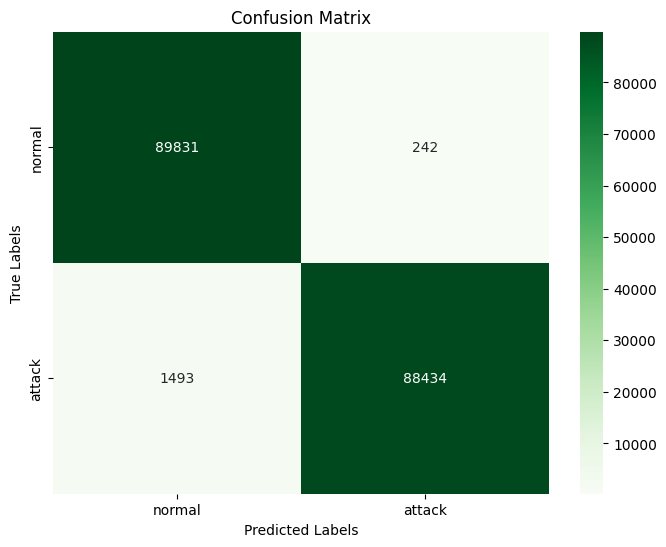

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Analyzing the precision score, f1-score and relevant evaluation metrics

In [45]:
class_labels=['normal', 'attack']

In [46]:
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

      normal       0.98      1.00      0.99     90073
      attack       1.00      0.98      0.99     89927

    accuracy                           0.99    180000
   macro avg       0.99      0.99      0.99    180000
weighted avg       0.99      0.99      0.99    180000



### ROC Curve (Receiver Operating Characteristic)

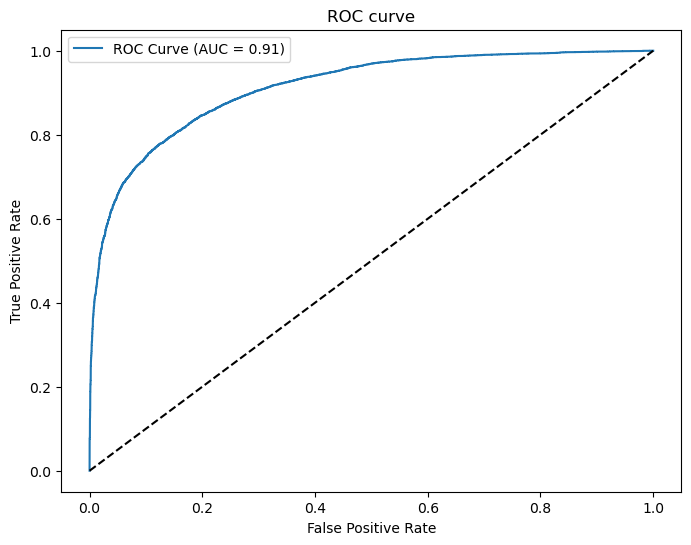

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()


### Creating a chart showing the accuracy level of the model between existing literature and this literature

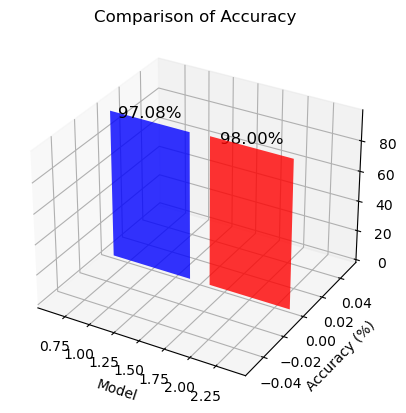

In [60]:
existing_literature_accuracy = 97.08
your_model_accuracy = 98

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

labels = ['Existing Literature', 'Your Model']
positions = [1, 2]
accuracies = [existing_literature_accuracy, your_model_accuracy]
ax.bar(positions, accuracies, zs=0, zdir='y', color=['blue', 'red'], alpha=0.8)
ax.set_title('Comparison of Accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')

for i in range(len(labels)):
    ax.text(positions[i], 0, accuracies[i] + 1, f'{accuracies[i]:.2f}%', ha='center', va='bottom', fontsize=12, color='black')
plt.show()



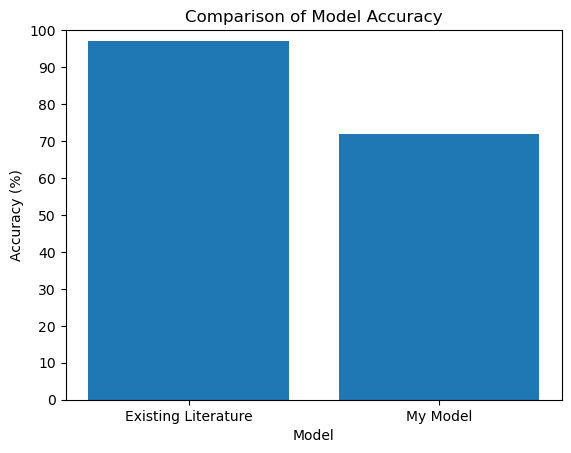

In [62]:
labels = ['Existing Literature', 'My Model']
accuracies = [97.08, 72]

plt.bar(labels, accuracies)
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracy')
plt.show()

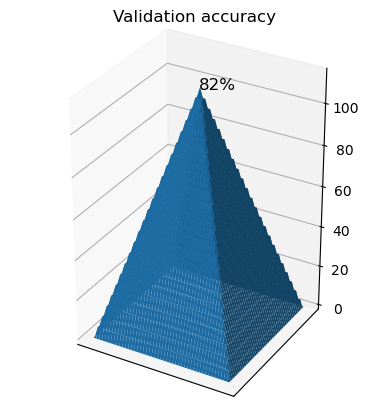

In [63]:
height = 230
Pyramid = np.zeros([height, 230])
x = Pyramid.shape[0]
y = Pyramid.shape[1]

for i in range(x // 2):
    for j in range(i, x - i):
        for h in range(i, x - i):
            Pyramid[j, h] = i * 1

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
x2d, y2d = np.meshgrid(range(x), range(y))
ax.plot_surface(x2d, y2d, Pyramid)

# Add the text annotation at the peak
peak_height = Pyramid.max()  # Assuming the peak is the maximum value in the Pyramid
peak_x, peak_y = np.unravel_index(Pyramid.argmax(), Pyramid.shape)
ax.text(peak_x, peak_y, peak_height, '82%', color='black', fontsize=12)

ax.set_box_aspect([13, 13, 20])
ax.set_xticks([])
ax.set_yticks([])

plt.title('Validation accuracy')
plt.show()

### Vizualize the Dataset

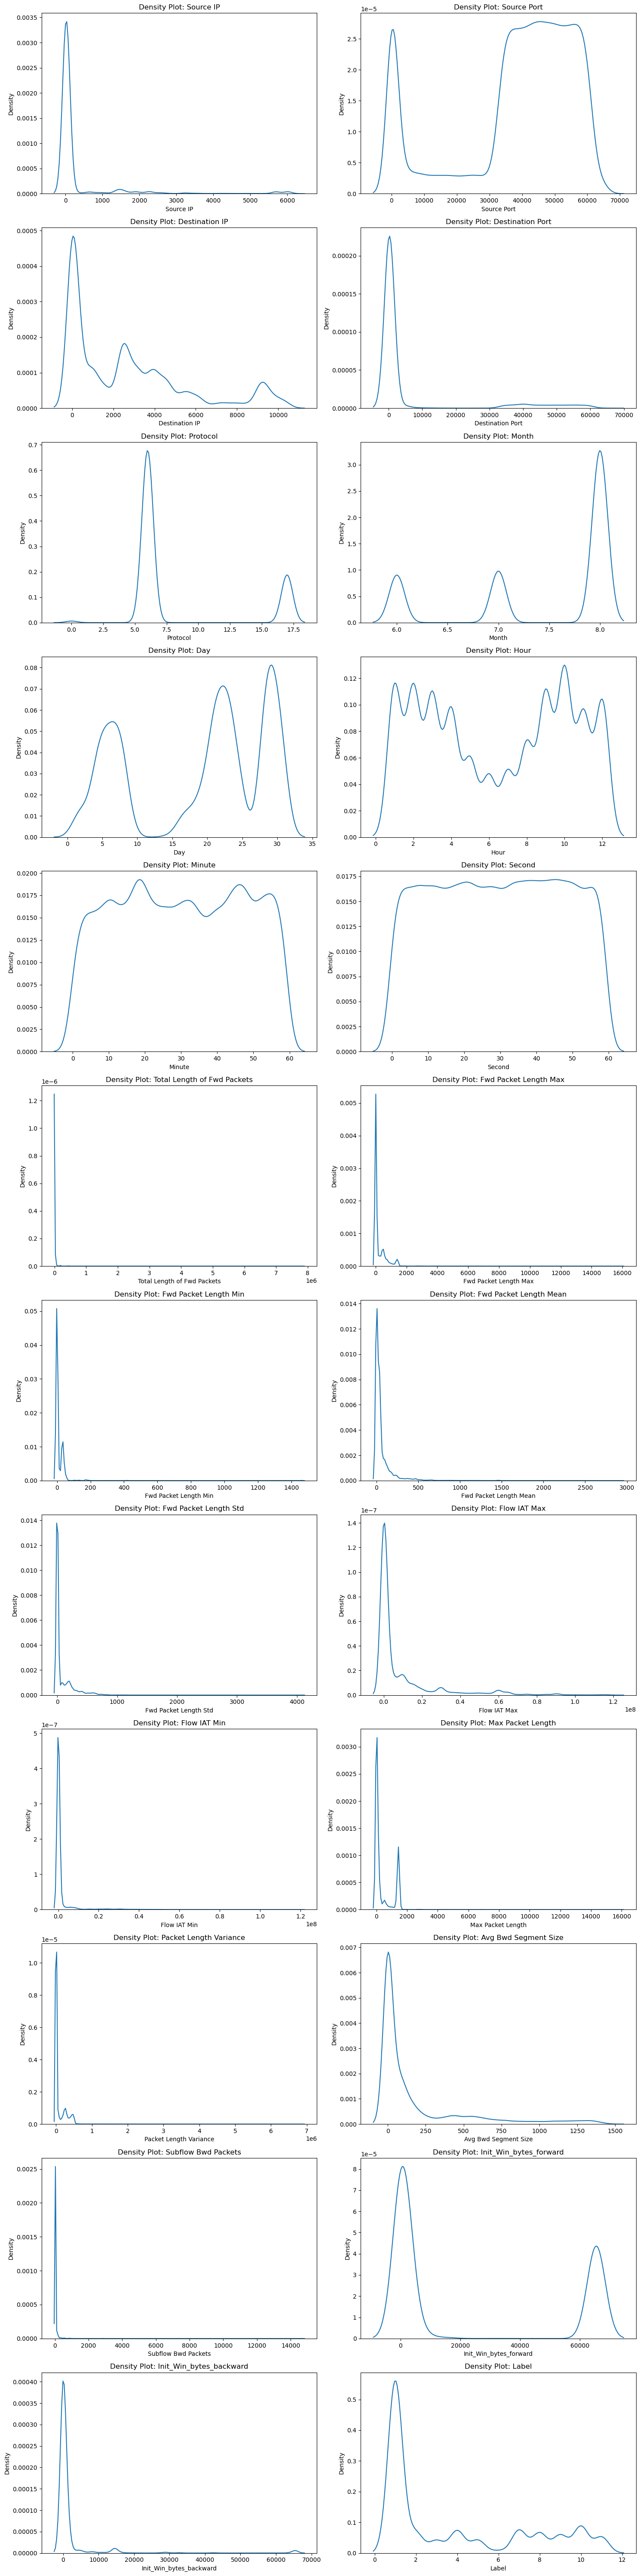

In [64]:
features_to_visualize = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 
                         'Protocol', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 
                     'Flow IAT Max', 'Flow IAT Min', 'Max Packet Length', 'Packet Length Variance', 
                     'Avg Bwd Segment Size', 'Subflow Bwd Packets', 'Init_Win_bytes_forward', 
                     'Init_Win_bytes_backward', 'Label']

num_rows = (len(features_to_visualize) + 1) // 2

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))


for i, feature in enumerate(features_to_visualize):
    row = i // 2  
    col = i % 2   
    
    sns.kdeplot(data=balanced_df, x=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Density Plot: {feature}')

if i < len(features_to_visualize) - 1:
    for j in range(i + 1, len(features_to_visualize)):
        row = j // 2
        col = j % 2
        fig.delaxes(axes[row, col])

plt.tight_layout()

# Save the entire figure as a single image
output_filename = 'all_density_plots.png'
plt.savefig(output_filename)
plt.show()

In [69]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred_decision_tree = decision_tree.predict(X_test)

# Evaluate the model's performance
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print("Decision Tree Accuracy:", accuracy_decision_tree)


Decision Tree Accuracy: 1.0


In [56]:
y_test.shape

(90000,)

In [70]:
log_model = LogisticRegression()

In [71]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [72]:
log_model.score(X_test, y_test)

1.0

In [74]:
log_y_pred = log_model.predict(X_test)
confusion = confusion_matrix(y_test, log_y_pred)

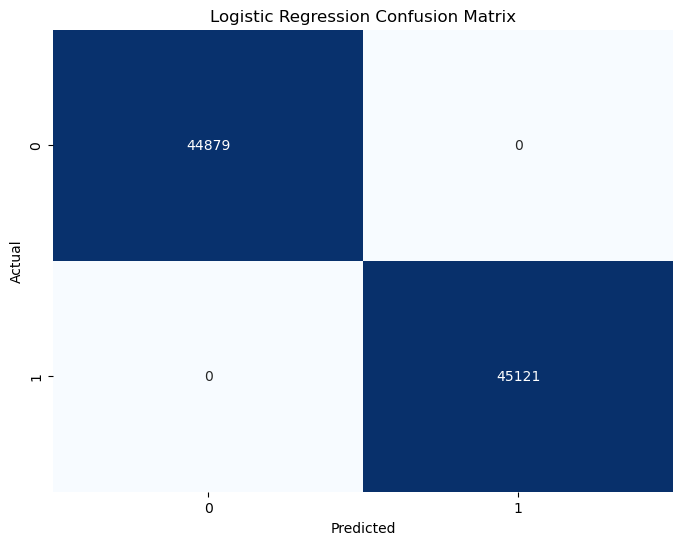

In [76]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [77]:
GB_model = GaussianNB()

In [78]:
GB_model.fit(X_train, y_train)

GaussianNB()

In [79]:
GB_model.score(X_test, y_test)

0.9997777777777778

In [80]:
gb_y_pred = GB_model.predict(X_test)
confusion = confusion_matrix(y_test, gb_y_pred)

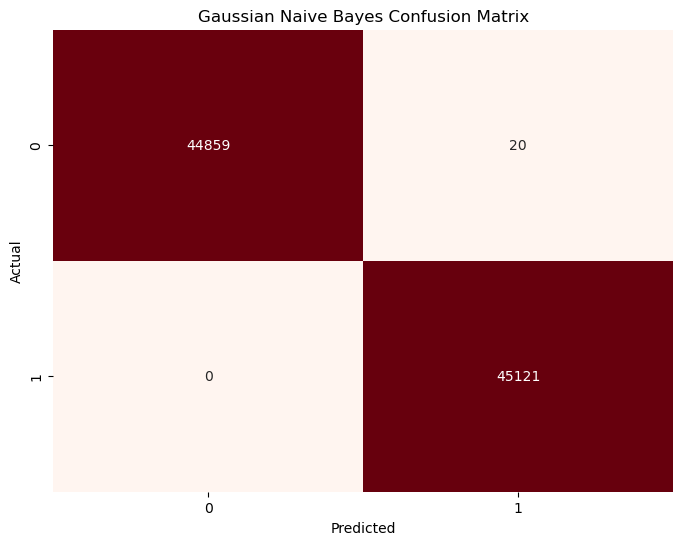

In [81]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()